In [47]:
#importi
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

In [48]:
print("loading orders...")
orders = pd.read_csv("data/orders.csv", dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print("loading products...")
products = pd.read_csv("data/products.csv", dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print("loading prior...")
prior = pd.read_csv("data/order_products__prior.csv", dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print("loading train...")
train = pd.read_csv("data/order_products__train.csv", dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
print("done")

loading orders...
loading products...
loading prior...
loading train...
done


In [49]:
### product features ###
print("calculating product features...")
prodf = pd.DataFrame()
prodf['orders'] = prior.groupby(prior.product_id).size().astype(np.int32) #number of orders
prodf['reorders'] = prior['reordered'].groupby(prior.product_id).sum().astype(np.float32) #number of reorders
prodf['reorder_rate'] = (prodf.reorders / prodf.orders).astype(np.float32) # ratio of reorders
products = products.join(prodf, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prodf

print("done")

calculating product features...
done


In [50]:
print('add order info to prior - merge')
orders.set_index('order_id', inplace=True, drop=False)
prior = prior.join(orders, on='order_id', rsuffix='_')
prior.drop('order_id_', inplace=True, axis=1)
print("done")

add order info to prior - merge
done


In [51]:
### user features ###
print("calculating user features...")
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32) #avg days between orders
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16) #number of orders

users = pd.DataFrame()
users['total_items'] = prior.groupby('user_id').size().astype(np.int16) #number of items bought
users['all_products'] = prior.groupby('user_id')['product_id'].apply(set) #set of products(id) bought !!!
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16) #number of distinct items bought

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32) #avg number of items in order
print('user f', users.shape)
print("done")

calculating user features...
user f (206209, 6)
done


In [52]:
### userXproduct features ###

print('calculating userXproduct features... slow...')
prior['user_product'] = prior.product_id + prior.user_id * 100000 ##user_product id  ???
prior['user_max_order_num'] = prior.groupby('user_id')['order_number'].transform('max')

# This was to slow !!
#def last_order(order_group):
#    ix = order_group.order_number.idxmax
#    return order_group.shape[0], order_group.order_id[ix],  order_group.add_to_cart_order.mean()
#userXproduct = pd.DataFrame()
#userXproduct['tmp'] = df.groupby('user_product').apply(last_order)

#slow code
d= dict()
for row in prior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order, 1 if row.order_number > row.user_max_order_num-5 else 0)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order, d[z][3]+1 if row.order_number > row.user_max_order_num-5 else d[z][3])

print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart', 'total_buys_n5']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
userXproduct.total_buys_n5 = userXproduct.total_buys_n5.astype(np.int16)
print('user X product f', len(userXproduct))

# userXproduct.total_buys_n5 = userXproduct.

#alegedly imporved code
# userXproduct = prior.copy()
# userXproduct['user_product'] = userXproduct.product_id + userXproduct.user_id * 100000
# userXproduct = userXproduct.sort_values('order_number')
# userXproduct = userXproduct \
#     .groupby('user_product', sort=False) \
#     .agg({'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})
# userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
# userXproduct.astype(
#     {'nb_orders': np.int16, 'last_order_id': np.int32, 'sum_pos_in_cart': np.int16}, 
#     inplace=True)

del prior
print("done")

calculating userXproduct features... slow...
to dataframe (less memory)
user X product f 13293564
done


In [54]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
print("done")

split orders : train, test
done


build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
formating for lgb
light GBM train :-)
done


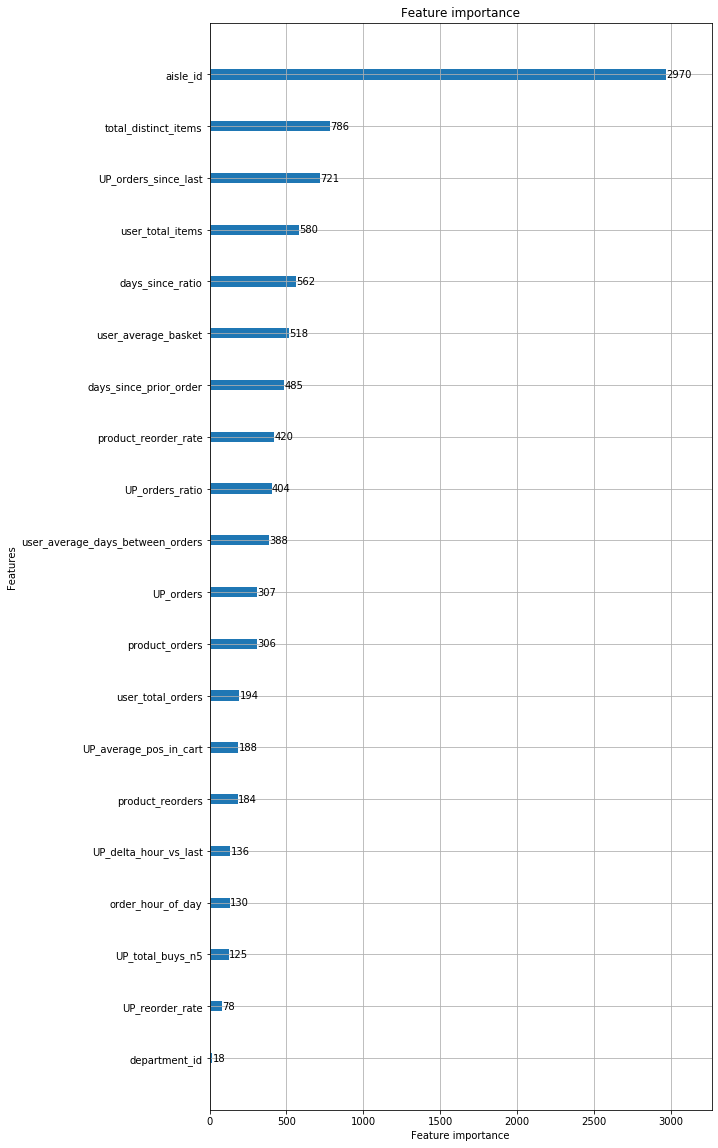

In [66]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    train_index = set(train.index)     
    i = 0 
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        user_id = row.user_id
        order_id = row.order_id
        user_prods = users['all_products'][user_id]
        product_list += user_prods
        order_list += [order_id] * len(user_prods)
        if labels_given:
            labels += [(order_id, prod) in train_index for prod in user_prods]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    df['UP_total_buys_n5'] = df.z.map(userXproduct.total_buys_n5)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    #print(df.dtypes)
    #print(df.memory_usage())
    return (df, labels)
    

df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last', 'UP_total_buys_n5'] # 'dow', 'UP_same_dow_as_last_order'


print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
lgb.plot_importance(bst, figsize=(9,20)) #importance plot
del d_train
print("done")

In [65]:
### build candidates list for test ###

df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('my_sub.csv', index=False)
print("done")

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features
light GBM predict
done


In [57]:
### TESTING ####

def eval_fun(labels, preds):
    labels = labels.split(' ')
    preds = preds.split(' ')
    rr = (np.intersect1d(labels, preds))
    precision = np.float(len(rr)) / len(preds)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)


###########
cv_labels_df = pd.read_csv('data/sample_submission.csv')
cv_labels_df['products'] = cv_labels_df['products'].astype(str)
cv_preds_df = pd.read_csv('2place.csv')
cv_preds_df['products'] = cv_preds_df['products'].astype(str)
cv_labels_df = pd.merge(cv_labels_df, cv_preds_df, how='left', on='order_id')
cv_labels_df.head()


,order_id,products_x,products_y
0,17,39276 29259,13107 21463 38777 47766 21709
1,34,39276 29259,16083 47766 39475 21137 43504 47792 13176 2596...
2,137,39276 29259,24852 23794 38689 41787 25890 2326 5134
3,182,39276 29259,5479 39275 9337 13629 11520 47672 41149 33000 ...
4,257,39276 29259,24852 49235 27966 37646 27104 39475 29837 3023...


In [58]:
cv_labels_df = pd.read_csv('data/sample_submission.csv')
cv_labels_df['products'] = cv_labels_df['products'].astype(str)
cv_preds_df = pd.read_csv('sub_kaggle.csv')
cv_preds_df['products'] = cv_preds_df['products'].astype(str)
cv_labels_df = pd.merge(cv_labels_df, cv_preds_df, how='left', on='order_id')
#cv_labels_df.head()

In [59]:
res = list()
for entry in cv_labels_df.itertuples():
    res.append(eval_fun(entry[2], entry[3]))

res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
res.describe()

,precision,recall,f1
count,75000.000000,75000.000000,75000.000000
mean,0.000563,0.001747,0.000750
std,0.013399,0.029501,0.014737
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,0.500000,0.666667
